# Libraries

Import all necessary libraries

In [1]:
# IO
import os
import shutil
import pathlib
from pathlib import Path
from glob import glob
import cv2
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union
from PIL import Image
import json
from rich.console import Console
from rich.markdown import Markdown

# Utilities
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize

import random
import math
from collections import defaultdict

from functools import partial

# Pytorch
import torch
import torchmetrics
from torch import nn

# Torchvision
import torchvision
from torchvision.datasets.vision import VisionDataset
from torchvision import datasets
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.io import read_image
## torchvision utilities
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.utils.data import Dataset
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader

# Optuna (hyperparameter search)
import optuna

# Visualization
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

#matplotlib.use(backend="TkAgg")
# Progress bar
import sys
from tqdm.notebook import tqdm

Check pytorch and torchvision versions

In [2]:
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.4.1.post102
torchvision version: 0.19.1a0+5ed21bd


# Functions and Classes definitions

## Data Preparation

Define set of image transformations, boolean switch for color images

In [3]:
def TransformationComposer(dimension=256, color=True):
    if color:
        return transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Resize(dimension),
            transforms.RandomCrop(dimension*(7/8)),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        return transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Resize(dimension),
            transforms.RandomCrop(dimension*(7/8)),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Grayscale(1)
        ])

This function scans the dataset folder, discarding images that are smaller than a target dimension Dim or just broken (NULL type). The discarded images are moved to another folder (BROKENDATA_FOLDER)

In [4]:
def ImageFolderScan(Dim):
    subfolder_list = glob(os.path.join(DATASET_FOLDER,"*","*",""), recursive = True)
    for i in range(len(subfolder_list)):
        for filename in os.listdir(subfolder_list[i]):
            image_path = str(subfolder_list[i]+filename)
            image = cv2.imread(image_path)
            # If pic is broken
            if image is None:
                os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)
            else:
                # If pic is too small, threshold 256x256
                height, width, channels = image.shape
                if min(height,width)<Dim:
                    os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)

Create a customized ImageFolder class so that we can define classes from subsubdirectories (used for the fine-grained classifier classifier)

Given how ImageFolder handles getting the datapoints, the elements in class_to_idx should resemble the relative path from the root directory

In [5]:
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        # Initialize the parent class (ImageFolder) correctly
        super().__init__(root, transform=transform)

    def find_classes(self, directory):
            subfolders = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
            
            classes = []
            class_to_idx = {}
            
            # Iterate over each subfolder
            for subfolder in subfolders:
                subfolder_path = os.path.join(directory, subfolder)
                # Get sub-subfolders
                for class_name in os.listdir(subfolder_path):
                    class_path = os.path.join(subfolder_path, class_name)
                    if os.path.isdir(class_path):
                        classes.append(os.path.join(subfolder, class_name))  # Add the class name
                        # Create a dictionary for classes and class indices
                        class_to_idx[os.path.join(subfolder, class_name)] = len(class_to_idx)

            return classes, class_to_idx

This class was created to reproduce the data structure of datasets created from ImageFolder for subsets of those datasets. It is not strictly necessary for training (we can directly load the subsets in DataLoader), but it can be useful for preliminary visualizations, such as class histograms.

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, data, indices, transform=None):
        self.data = data  # Assuming `data` is similar to ImageFolder with `samples` and `targets`
        self.indices = indices  # Indices to select specific data points
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Retrieve the sample (img_path, label) using the provided indices
        img_path, label = self.data.samples[self.indices[idx]]
        
        # Open the image and apply any transformations
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

    @property
    def samples(self):
        # Return the subset of samples based on the provided indices
        #return [(self.data.samples[i][0], self.data.samples[i][1]) for i in self.indices]
        return [self.data.samples[i] for i in self.indices]

    @property
    def images(self):
        # Return the subset of samples based on the provided indices
        return [self.data.samples[i][0] for i in self.indices]

    @property
    def targets(self):
        # Return the labels for the subset of samples
        return [self.data.samples[i][1] for i in self.indices]
        
    @property
    def classes(self):
        return self.data.classes  # Exposing classes from parent dataset

Function that handles stratified sampling, returning the indices for the train/test splits.

In [7]:
def StratifiedSplit(data, test_size_fraction=0.3):
    targets = np.array(data.targets)
    train_idx, test_idx = train_test_split(
        np.arange(len(data)),
        test_size=test_size_fraction,
        shuffle=True,
        stratify=targets
    )

    # Return indices only
    return train_idx, test_idx


Create a function that splits the data into two folders, corresponding to train and test, using StratifiedSplit. This makes it possible to train the same model multiple times and gives easy access to the test set.

In [8]:
def copy_images(dataset, indices, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)

    for idx in indices:
        img_path, label = dataset.samples[idx]
        class_name = dataset.classes[label]  # Get class name from label

        # Create class and subclass subfolder structure in destination
        subclass_folder = os.path.join(dest_folder, class_name)
        os.makedirs(subclass_folder, exist_ok=True)

        # Copy the image to the corresponding subclass folder
        shutil.copy(img_path, os.path.join(subclass_folder, os.path.basename(img_path)))


In [9]:
def create_train_test_folders(StratifiedSplit):
    # Load dataset
    dataset = CustomImageFolder(DATASET_FOLDER)

    # Perform stratified split to get train/test indices
    train_indices, test_indices = StratifiedSplit(dataset, test_size_fraction=0.2)

    # Copy images to new folders, preserving class/subclass structure
    copy_images(dataset, train_indices, TRAIN_FOLDER)
    copy_images(dataset, test_indices, TEST_FOLDER)

    print(f"Images successfully split into {TRAIN_FOLDER} and {TEST_FOLDER}")


Create a function that handles the entirety of data preparation. `fine_grained_classifier` is a bool variable that encodes whether we want to build a model with a more fine-grained classifier or not. We need it here to decide how to load the dataset. `data_clean` is a bool variable that handles whether or not to scan the data folder for broken or very small images; if this process was done in a previous run, we don't need to do it again.

TODO directory structure

In [10]:
def DataPreparation(
    transform,
    dim,
    fine_grained_classifier = False,
    split_bool = False,
    data_clean = False,
):
    if data_clean: # if true clean the data folder
        ImageFolderScan(dim)

    if split_bool: # if true split the data into train and test using a stratified split
        create_train_test_folders(StratifiedSplit)

    # Import the train dataset
    if fine_grained_classifier: # if true, use the custom ImageFolder class
        train_dataset = CustomImageFolder(TRAIN_FOLDER, transform=transform)
        test_dataset = CustomImageFolder(TEST_FOLDER, transform=transform)
        dataset = CustomImageFolder(DATASET_FOLDER, transform=transform)
    else: # if false, use default image folder
        train_dataset = ImageFolder(TRAIN_FOLDER, transform=transform)
        test_dataset = ImageFolder(TEST_FOLDER, transform=transform)
        dataset = ImageFolder(DATASET_FOLDER, transform=transform)

    ## Create an inverse label map
    label_dictionary = dict((v, str(os.path.basename(os.path.normpath(k)))) for k, v in dataset.class_to_idx.items())

    return dataset, train_dataset, test_dataset, label_dictionary


## Visualizations

Visualize Stratified Kfold as seen in the [scikit learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py) using the next two functions.

In [11]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, train_title='Training set', test_title='Testing set'):
    """Create a sample plot for indices of a cross-validation object."""
    # Sort X and y according to y to keep the classes in order
    sorted_indices = np.argsort(y)
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]

    # Define colormaps for CV splits and data classes
    cmap_cv = plt.cm.coolwarm  # Used for training/testing splits
    cmap_data = plt.cm.tab10  # Used for data classes

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X_sorted, y=y_sorted)):
        # Fill in indices with the training/test labels
        indices = np.array([np.nan] * len(X_sorted))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes at the end
    # Use class labels as colors with a unique color per class
    unique_classes = np.unique(y_sorted)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_classes) + 1) - 0.5, ncolors=len(unique_classes))
    scatter = ax.scatter(
        range(len(X_sorted)),
        [ii + 1.5] * len(X_sorted),
        c=y_sorted,
        marker="_",
        lw=lw,
        cmap=cmap_data,
        norm=norm
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X_sorted)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

    # Create combined legend
    # Legend for CV splits (Training and Testing)
    test_title_str = test_title
    train_title_str = train_title

    handles_cv = [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))]
    labels_cv = [test_title, train_title]

    # Legend for class labels
    legend_labels = [f"Class {cls}" for cls in unique_classes]
    handles_classes = scatter.legend_elements()[0]  # Extract handles for the class labels

    # Combine handles and labels for both legends
    handles = handles_cv + handles_classes
    labels = labels_cv + legend_labels

    # Add the combined legend
    ax.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(1.05, 1))

    return ax

In [12]:
def StratifiedKFoldVisual(dataset, cv, mask_len = 3, train_title='Training set', test_title='Testing set'):
    X = [sample[0] for sample in dataset.samples]  # Paths or images
    y = dataset.targets  # Labels (class indices)

    unique_classes = np.unique(y)[:mask_len]
    mask = np.isin(y, unique_classes)

    X_limited = np.array(X)[mask]
    y_limited = np.array(y)[mask]

    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm

    fig, ax = plt.subplots()
    plot_cv_indices(cv, X_limited, y_limited, ax, cv.get_n_splits(), train_title=train_title, test_title=test_title)

Plot the loss and accuracy per epoch corresponding to the best trial of the hyperparameter search

In [13]:
def hyperparameter_report(best_trial):
    # Retrieve attributes
    ## Validation losses, training losses, and accuracies
    best_val_losses = best_trial.user_attrs.get("val_losses_over_folds", None)
    best_train_losses = best_trial.user_attrs.get("train_losses_over_folds", None)
    best_val_accs = best_trial.user_attrs.get("val_accs_over_folds", None)
    best_train_accs = best_trial.user_attrs.get("train_accs_over_folds", None)
    
    if not all([best_val_losses, best_train_losses, best_val_accs, best_train_accs]):
        raise ValueError("The best trial does not have necessary metrics stored in its user attributes.")

    # Aggregate across folds (padding for alignment)
    def aggregate_folds(fold_data):
        return np.array([
            np.pad(fold, (0, max(map(len, fold_data)) - len(fold)), mode='constant', constant_values=np.nan)
            for fold in fold_data
        ])

    # Aggregate metrics across folds
    val_losses_array = aggregate_folds(best_val_losses)
    train_losses_array = aggregate_folds(best_train_losses)
    val_accs_array = aggregate_folds(best_val_accs)
    train_accs_array = aggregate_folds(best_train_accs)

    # Compute mean and standard deviation across folds
    mean_val_loss = np.nanmean(val_losses_array, axis=0)
    std_val_loss = np.nanstd(val_losses_array, axis=0)

    mean_train_loss = np.nanmean(train_losses_array, axis=0)
    std_train_loss = np.nanstd(train_losses_array, axis=0)

    mean_val_acc = np.nanmean(val_accs_array, axis=0)
    std_val_acc = np.nanstd(val_accs_array, axis=0)

    mean_train_acc = np.nanmean(train_accs_array, axis=0)
    std_train_acc = np.nanstd(train_accs_array, axis=0)

    # Plot
    epochs = range(1, len(mean_val_loss) + 1)

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot validation loss and training loss with standard deviations
    ax1.plot(epochs, mean_val_loss, label="Mean Validation Loss", color='tab:blue')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.2, label="±Std Validation Loss")
    ax1.plot(epochs, mean_train_loss, label="Mean Training Loss", color='tab:orange')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.2, label="±Std Training Loss")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss and Accuracy (Best Hyperparameters)")
    ax1.legend(loc="upper left")

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, mean_train_acc, label="Mean Training Accuracy", color='tab:green')
    ax2.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:green', alpha=0.2, label="±Std Training Accuracy")
    ax2.plot(epochs, mean_val_acc, label="Mean Validation Accuracy", color='tab:red')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:red', alpha=0.2, label="±Std Validation Accuracy")

    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper right")
    
    # Show plot
    plt.show()

    return


Plot losses and accuracies per epoch during training

In [14]:
def training_report(log_file_path):
    # Check if the log file exists and is not empty
    if not os.path.exists(log_file_path) or os.stat(log_file_path).st_size == 0:
        print("The log file does not exist or is empty. Cannot plot metrics.")
        return
    
    # Initialize lists to store data
    epochs = []
    training_loss = []
    training_acc = []
    validation_loss = []
    validation_acc = []

    # Read the log file
    with open(log_file_path, "r") as log_file:
        # Skip the header
        next(log_file)
        # Parse the content
        for line in log_file:
            values = line.strip().split('\t')
            epochs.append(int(values[0]))
            training_loss.append(float(values[1]))
            training_acc.append(float(values[2]))
            validation_loss.append(float(values[3]))
            validation_acc.append(float(values[4]))

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss', marker='o')
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, validation_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    # Show the plots
    plt.tight_layout()
    plt.show()

Build a function that handles all pre-training visualizations.

In [15]:
def VisualizeData(
    dataset,
    train_dataset,
    test_dataset
):
    console = Console()

    # First plot
    console.print(Markdown("### Class exploration\nCheck whether classes are imbalanced, if so, stratified sampling is necessary."))
    plt.hist([dataset[idx][1] for idx in range(len(dataset))], bins=len(dataset.classes))
    plt.title('Dataset class distribution')
    plt.show()

    # Second plot

    console.print(Markdown("#### Stratified train-test split\nAfter splitting the dataset into training and testing, taking into account the class distribution, we check whether the new distributions resemble the original."))
    
    plt.hist([train_dataset[idx][1] for idx in range(len(train_dataset))], bins=len(dataset.classes))
    plt.title('Test set class distribution')
    plt.show()

    plt.hist([test_dataset[idx][1] for idx in range(len(test_dataset))], bins=len(dataset.classes))
    plt.title('Test set class distribution')
    plt.show()

    # Third plot
    
    console.print(Markdown("### Visualizing stratified K-fold sampling\nVisualize how data is split under stratified K-fold sampling. For the sake of clarity, we only plot the first 4 classes."))
    
    splits = 4
    reps = 2
    rskf = RepeatedStratifiedKFold(n_repeats=reps, n_splits=splits)
    skf = StratifiedKFold(n_splits=splits, shuffle=False)

    StratifiedKFoldVisual(train_dataset, rskf, mask_len = 4, test_title='Validation set')
    plt.show()
    StratifiedKFoldVisual(train_dataset, skf, mask_len = 4, test_title='Validation set')
    plt.show()

    # Fourth plot

    console.print(Markdown("#### Class distribution after stratified K-fold\nThe `split` method in (Repeated)StratifiedKFold returns the array of indices relative to a the test and validation set of a given fold.\nHere, we check whether one of these folds respects the original class distribution"))
    
    X_train = np.array([sample[0] for sample in train_dataset.samples])
    y_train = np.array([sample[1] for sample in train_dataset.samples])

    for fold, (train_index, val_index) in enumerate(rskf.split(X_train, y_train)):
        if fold == 0:  # Only take the first fold
            train_fold_sub = torch.utils.data.Subset(train_dataset, train_index)
            val_fold_sub = torch.utils.data.Subset(train_dataset, val_index)
            break  # Exit after the first fold
    plt.hist(train_fold_sub.dataset.targets, bins=len(dataset.classes))
    plt.title('Train set class distribution')
    plt.show()

    # Fifth plot

    console.print(Markdown("### Check if images load correctly\nDisplay 16 random images from the train dataset."))

    label_dictionary = dict((v, str(os.path.basename(os.path.normpath(k)))) for k, v in dataset.class_to_idx.items())

    fig = plt.figure(figsize=(15, 15))
    rows, cols = 4, 4
    for i in range(1, rows * cols + 1):
        random_idx = random.randint(0, len(train_dataset)-1)
        img = train_dataset[random_idx][0]
        label = label_dictionary[train_dataset[random_idx][1]]
        fig.add_subplot(rows, cols, i)
        img = img.permute(1,2,0)
        plt.imshow(img, cmap = "binary", interpolation = "nearest")
        plt.title(label)
        plt.axis(False);
    plt.show()

    return

## Training

Basic training loop (one epoch)

In [16]:
def training_epoch(model, optimizer, loss_crit, train_loader, device):
    avg_train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Load batches and train
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(batch_x)

        # Compute loss
        loss = loss_crit(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Accumulate train loss
        avg_train_loss += loss.item()

        # Accumulate train accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)
    
    # Average training loss and accuracy over batches
    avg_train_loss /= len(train_loader)
    avg_train_accuracy = correct_train / total_train

    return avg_train_loss, avg_train_accuracy

Basic validation loop, returning validation loss and accuracy averaged on batches

In [17]:
def validation_epoch(model, criterion, val_loader, device):
    avg_val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # No training
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to device
            outputs = model(batch_x)

            # Compute loss
            loss = criterion(outputs, batch_y)

            # Accumulate train loss
            avg_val_loss += loss.item()

            # Accumulate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)

    
    # Average validation loss for the fold
    avg_val_loss /= len(val_loader)
    avg_val_accuracy = correct_val / total_val
    
    return avg_val_loss, avg_val_accuracy

Class that handles early stopping.

The early stop method checks whether the validation loss is not decreasing anymore, allowing for some "patience" steps and a minimum amount (delta) it needs to decrease for the training not to stop.

The reset method is necessary when running multiple trainings, eg in hyperparameter search.

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, compare_steps=5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.compare_steps = compare_steps
        self.loss_history = []

    def early_stop(self, validation_loss):
        self.loss_history.append(validation_loss)

        # Update best validation loss
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.reset()  # Reset state before stopping
                return True

        # Compare current loss with `compare_steps` earlier
        if len(self.loss_history) > self.compare_steps:
            if validation_loss >= (self.loss_history[-(self.compare_steps + 1)] - self.min_delta):
                self.reset()  # Reset state before stopping
                return True

        # Maintain history size
        if len(self.loss_history) > self.compare_steps + 1:
            self.loss_history.pop(0)

        return False

    def reset(self):
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.loss_history = []

Final training loop.

If we have an hyperparameter list, the function reads the list and selects these hyperparameters as provided, otherwise they are defaulted to given values.

predef_bool handles wheter 

In [19]:
def train_loop(dataset, model_class, hyperparams, criterion, device, early_stopper, out_str, predef_bool=True, max_epochs=100):
    # Get hyperparameters from best study
    batch_size = hyperparams.get('batch_size', 32)  # Default to 32 if not provided
    learning_rate = hyperparams.get('lr', 0.001)  # Default to 0.001 if not provided
    optimizer_name = hyperparams.get('optimizer_name', 'Adam')  # Default to Adam if not provided
    wd = hyperparams.get('weight_decay', 0.001) # Default to 0.001 if not provided
    hidden_channels = hyperparams.get('hidden_channels', None) # Default to None if not provided


    if predef_bool: # Pretrained model, we only focus on fine-tuning
        model = model_class(pretrained=True)
        # Fine-tune
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(dataset.classes), bias=True)
        for param in model.features:
            param.requires_grad = False

    else:
        model = model_class(n_channels=1, hidden_channels=hidden_channels, output_shape=len(set(dataset.targets)))

    model.to(device)
    #criterion.to(device)

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate, weight_decay=wd)

    # Check if the file is empty or does not exist
    if not os.path.exists(out_str) or os.stat(out_str).st_size == 0:
        # File does not exist or is empty, create it
        log_file = open(out_str, "w")
        log_file.write('epoch'+'\t'+'training_loss'+'\t'+'training_acc'+'\t'+'validation_loss'+'\t'+'validation_acc'+'\n')
    else:
        # File exists, append
        log_file = open(out_str, "a")

    torch.manual_seed(42)

    # Create indices for stratified split
    train_idx, val_idx = StratifiedSplit(dataset, test_size_fraction=0.2)

    # Create data subsets for train and validarion
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    # Create loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    total_step = len(train_loader)

    for epoch in range(max_epochs):
        model.train()
        print(f'Train step, epoch: {epoch+1}')
        train_loss, train_acc = training_epoch(model, optimizer, criterion, train_loader, device)
        print(f'Epoch: {epoch+1}, train loss = {train_loss}, train accuracy = {train_acc}')

        # Early stopping and validation
        print(f'Val step, epoch: {epoch+1}')
        model.eval()
        val_loss, val_acc = validation_epoch(model, criterion, val_loader, device)
        print(f'Epoch: {epoch+1}, validation loss = {val_loss}, validation accuracy = {val_acc}')

        if early_stopper.early_stop(val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Logging
        log_file.write(f"{epoch}\t{train_loss:.4f}\t{train_acc:.4f}\t{val_loss:.4f}\t{val_acc:.4f}\n")

    log_file.close()
    return model

### Hyperparameter tuning

Cross Validation training.
We are using the Optima library to search the optimal hyperparameters.

An early stopping policy is implemented to reduce run time and avoid overfitting.

We have to train independently over the folds

The hyperparameters to be searched are:
- batch size
- optimizer
- learning rate (logarithmic sampling)
- weight decay (logarithmic sampling)

Wrapper for objective function

In [20]:
def create_objective_fn(
    dataset, 
    model_class, 
    criterion, 
    cross_validator, 
    device, 
    early_stopper, 
    predef_bool=True, 
    coppo_bool_light=False
    ):
    def objective_fn(trial):
        return objective(
            trial, 
            dataset, 
            model_class, 
            criterion, 
            cross_validator, 
            device, 
            early_stopper,
            predef_bool,
            coppo_bool_light
        )
    return objective_fn


Objective function

In [21]:
def objective(
    trial, 
    dataset, 
    model_class, 
    criterion, 
    cross_validator, 
    device, 
    early_stopper,
    predef_bool=True, # Check whether to use a predefined model or a custom one
    coppo_bool_light=False # Decides the set of hidden channel choices for lighter or heavier model
    ):

    max_epochs = 10

    # Sample hyperparameters
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    wd = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)

    # Ensure model and criterion are on the correct device
    if predef_bool: # Pretrained model, we only focus on fine-tuning
        model = model_class(pretrained=True)
        # Fine-tune
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(dataset.classes), bias=True)
        for param in model.features:
            param.requires_grad = False

    else:
        if coppo_bool_light:
            # Define possible channel configurations
            hidden_channel_choices = [
                [4, 8, 16, 32],
                [6, 16, 32, 64],
                [3, 9, 15, 45]
            ]
            hidden_channels = trial.suggest_categorical("hidden_channels", hidden_channel_choices)
        else:
            # Define possible channel configurations
            hidden_channel_choices = [
                [4, 8, 16, 32, 48, 64],
                [6, 16, 32, 64, 96, 128],
                [3, 9, 15, 30, 45, 90]
            ]
            hidden_channels = trial.suggest_categorical("hidden_channels", hidden_channel_choices)
        model = model_class(n_channels=1, hidden_channels=hidden_channels, output_shape=len(set(dataset.targets)))

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd)

    model.to(device)
    #criterion.to(device)

    # Split into image and targets for the cross validator split
    X_train = np.array([sample[0] for sample in dataset.samples])
    y_train = np.array([sample[1] for sample in dataset.samples])

    # To store validation and training losses and accuracies for each fold
    val_losses_over_folds = []
    train_losses_over_folds = []
    val_accs_over_folds = []
    train_accs_over_folds = []
    '''
    val_ndcgs_over_folds = []
    train_ndcgs_over_folds = []
    '''

    for fold, (train_idx, val_idx) in enumerate(tqdm(cross_validator.split(X_train, y_train), desc="Folds", unit="fold")):
        early_stopper.reset()
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        val_losses = []
        train_losses = []
        val_accs = []
        train_accs = []

        '''
        train_ndcgs = []
        val_ndcgs = []
        '''

        model_copy = model
        model_copy.to(device)

        for epoch in tqdm(range(max_epochs), desc=f"Fold {fold + 1} Epochs", unit="epoch", leave=False):
            model_copy.train()
            train_loss, train_acc = training_epoch(model_copy, optimizer, criterion, train_loader, device)

            model_copy.eval()
            val_loss, val_acc = validation_epoch(model_copy, criterion, val_loader, device)
            if early_stopper.early_stop(val_loss):
                break

            val_losses.append(val_loss)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            #val_ndcgs.append(val_ndcg)
            #train_ndcgs.append(train_ndcg)

        train_losses_over_folds.append(train_losses)
        train_accs_over_folds.append(train_accs)
        #train_ndcgs_over_folds.append(train_ndcgs)
        val_losses_over_folds.append(val_losses)
        val_accs_over_folds.append(val_accs)
        #val_ndcgs_over_folds.append(val_ndcgs)

    avg_last_val_loss = np.mean([losses[-1] for losses in val_losses_over_folds])
    trial.set_user_attr("val_losses_over_folds", val_losses_over_folds)
    trial.set_user_attr("train_losses_over_folds", train_losses_over_folds)
    trial.set_user_attr("val_accs_over_folds", val_accs_over_folds)
    trial.set_user_attr("train_accs_over_folds", train_accs_over_folds)
    '''
    trial.set_user_attr("val_ndcgs_over_folds", val_ndcgs_over_folds)
    trial.set_user_attr("train_ndcgs_over_folds", train_ndcgs_over_folds)
    '''

    return avg_last_val_loss

Hyperparameter report

Save best parameters to file

In [22]:
def save_best_trial_to_file(filepath, best_trial):
    # Extract parameters and user attributes
    best_params = best_trial.params
    best_user_attrs = best_trial.user_attrs

    # Combine them into a single dictionary
    output_data = {
        "Best Trial": {
            "Params": best_params,
            "User Attrs": best_user_attrs
        }
    }

    # Write to a JSON file
    with open(filepath, "w") as file:
        json.dump(output_data, file, indent=4)

    print(f"Best trial saved to {filepath}")


Load best trial

In [23]:
class BestTrial:
    def __init__(self, params, user_attrs):
        self.params = params
        self.user_attrs = user_attrs

In [24]:
def load_best_trial_from_file(filepath):
    with open(filepath, "r") as file:
        data = json.load(file)
    
    # Extract Params and User Attrs
    best_params = data["Best Trial"]["Params"]
    best_user_attrs = data["Best Trial"]["User Attrs"]
    
    return BestTrial(best_params, best_user_attrs)

Report

In [25]:
def hyperparameter_report(best_trial):
    # Retrieve attributes
    ## Validation losses, training losses, and accuracies
    best_val_losses = best_trial.user_attrs.get("val_losses_over_folds", None)
    best_train_losses = best_trial.user_attrs.get("train_losses_over_folds", None)
    best_val_accs = best_trial.user_attrs.get("val_accs_over_folds", None)
    best_train_accs = best_trial.user_attrs.get("train_accs_over_folds", None)
    '''
    best_val_ndcgs = best_trial.user_attrs.get("val_ndcgs_over_folds", None)
    best_train_ndcgs = best_trial.user_attrs.get("train_ndcgs_over_folds", None)
    '''
    
    if not all([best_val_losses, best_train_losses, best_val_accs, best_train_accs]):
        raise ValueError("The best trial does not have necessary metrics stored in its user attributes.")

    # Aggregate across folds (padding for alignment)
    def aggregate_folds(fold_data):
        return np.array([
            np.pad(fold, (0, max(map(len, fold_data)) - len(fold)), mode='constant', constant_values=np.nan)
            for fold in fold_data
        ])

    # Aggregate metrics across folds
    val_losses_array = aggregate_folds(best_val_losses)
    train_losses_array = aggregate_folds(best_train_losses)
    val_accs_array = aggregate_folds(best_val_accs)
    train_accs_array = aggregate_folds(best_train_accs)
    '''
    val_ndcgs_array = aggregate_folds(best_val_ndcgs)
    train_ndcgs_array = aggregate_folds(best_train_ndcgs)
    '''

    # Compute mean and standard deviation across folds
    mean_val_loss = np.nanmean(val_losses_array, axis=0)
    std_val_loss = np.nanstd(val_losses_array, axis=0)

    mean_train_loss = np.nanmean(train_losses_array, axis=0)
    std_train_loss = np.nanstd(train_losses_array, axis=0)

    mean_val_acc = np.nanmean(val_accs_array, axis=0)
    std_val_acc = np.nanstd(val_accs_array, axis=0)

    mean_train_acc = np.nanmean(train_accs_array, axis=0)
    std_train_acc = np.nanstd(train_accs_array, axis=0)

    '''
    mean_val_ndcg = np.nanmean(val_ndcgs_array, axis=0)
    std_val_ndcg = np.nanstd(val_ndcgs_array, axis=0)

    mean_train_ndcg = np.nanmean(train_ndcgs_array, axis=0)
    std_train_ndcg = np.nanstd(train_ndcgs_array, axis=0)
    '''

    # Plot
    epochs = range(1, len(mean_val_loss) + 1)

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot validation loss and training loss with standard deviations
    ax1.plot(epochs, mean_val_loss, label="Mean Validation Loss", color='tab:blue')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.2, label="±Std Validation Loss")
    ax1.plot(epochs, mean_train_loss, label="Mean Training Loss", color='tab:orange')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.2, label="±Std Training Loss")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss and Accuracy (Best Hyperparameters)")
    ax1.legend(loc="upper left")

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, mean_train_acc, label="Mean Training Accuracy", color='tab:green')
    ax2.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:green', alpha=0.2, label="±Std Training Accuracy")
    ax2.plot(epochs, mean_val_acc, label="Mean Validation Accuracy", color='tab:red')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:red', alpha=0.2, label="±Std Validation Accuracy")

    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper right")

    # Create a third y-axis for ndcg
    '''
    ax3 = ax2.twinx()
    ax3.plot(epochs, mean_train_ndcg, label="Mean Training Accuracy", color='tab:teal')
    ax3.fill_between(epochs, mean_train_ndcg - std_train_ndcg, mean_train_ndcg + std_train_ndcg, color='tab:teal', alpha=0.2, label="±Std Training Accuracy")
    ax3.plot(epochs, mean_val_ndcg, label="Mean Validation Accuracy", color='tab:yellow')
    ax3.fill_between(epochs, mean_val_ndcg - std_val_ndcg, mean_val_ndcg + std_val_ndcg, color='tab:yellow', alpha=0.2, label="±Std Validation Accuracy")

    ax3.set_ylabel("NDCG")
    ax3.legend(loc="upper right")
    '''
    # Show plot
    plt.show()

    return


In [26]:
def hyper_search(
    study,
    train_dataset,
    model_class,
    device,
    early_stop,
    criterion,
    predef_bool,
    coppo_bool_light,
    cross_validator=StratifiedKFold(n_splits=3)
    ):
    # Create Optuna study and optimize with additional parameters, study initialized outside with:
    # study = optuna.create_study(direction="minimize")

    objective_fn = create_objective_fn(
        dataset=train_dataset,
        model_class=model_class,
        criterion=criterion,
        cross_validator=cross_validator,
        device=device,
        early_stopper=early_stop,
        predef_bool=predef_bool,
        coppo_bool_light=coppo_bool_light
    )
    study.optimize(objective_fn, n_trials=15, n_jobs=5)
    return study

## Testing

Define a function that handles post-training testing.

In [63]:
def TestReport(
    model,
    device,
    test_dataset
):
    # Load data
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Instance performance metrics
    num_classes = len(test_dataset.classes)
    top1_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
    top3_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=3)
    f1_macro_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")
    f1_weighted_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="weighted")

    # Collect all predictions and targets for confusion matrix
    all_preds = []
    all_targets = []

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():  # No gradients needed for evaluation
        for batch in test_loader:  # Iterate over validation DataLoader
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits = model(images)  # Get raw predictions

            # Convert logits to predictions
            _, preds = torch.max(logits, dim=1)  # Top-1 predictions

            # Update batch-wise metrics
            top1_metric.update(preds, labels)
            top3_metric.update(logits, labels)  # Top-3 uses raw logits
            f1_macro_metric.update(preds, labels)
            f1_weighted_metric.update(preds, labels)

            # Store predictions and targets for confusion matrix
            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.cpu().numpy())


    # Compute final accumulated metrics after all batches are processed
    top1_acc = top1_metric.compute().item()
    top3_acc = top3_metric.compute().item()
    f1_macro = f1_macro_metric.compute().item()
    f1_weighted = f1_weighted_metric.compute().item()

    print(f"Top-1 Accuracy: {top1_acc:.4f}")
    print(f"Top-3 Accuracy: {top3_acc:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")

    # Compute Confusion Matrix
    all_preds = np.concatenate(all_preds)  # Flatten list of arrays
    all_targets = np.concatenate(all_targets)

    cm = confusion_matrix(all_targets, all_preds)

    # Visualize the confusion matrix using seaborn:
    class_labels = [test_dataset.classes[i] for i in sorted(np.unique(all_targets))]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Print Classification Report
    report = classification_report(all_targets, all_preds, target_names=[class_labels[i] for i in range(num_classes)])
    print(report)



## Main train function

In [28]:
def Train(
    transform,
    dim,
    model_class,
    criterion,
    fine_grained_classifier=False,
    split_bool = False,
    data_clean=False,
    data_visualization=True,
    device=None,
    early_stop=None,
    hyper_out_str=None,
    train_out_str=None,
    hyper_bool=True,
    train_bool=True,
    predef_bool=True,
    coppo_bool_light=False,
    best_pars=None
    ):

    # Set device dynamically
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare data
    dataset, train_dataset, test_dataset, label_dictionary = DataPreparation(
        transform,
        dim,
        fine_grained_classifier=fine_grained_classifier,
        split_bool = split_bool,
        data_clean=data_clean
    )

    # Data visualization
    ## only runs if data_visualization is set to True
    if data_visualization:
        VisualizeData(
            dataset,
            train_dataset,
            test_dataset
        )

    # Training and hyperparameter search
    model = None
    study = None

    ## Hyperparameter search

    if hyper_bool: # perform hyperparameter search if true
        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
        study = hyper_search(
            study,
            train_dataset,
            model_class,
            device,
            early_stop,
            criterion,
            predef_bool,
            coppo_bool_light
            )
        best_trial = study.best_trial
        save_best_trial_to_file(hyper_out_str, best_trial)
        hyperparameter_report(best_trial)
        print("Best hyperparameters:", study.best_params)
        print("Best validation loss:", study.best_value)
        best_pars = study.best_params
    if train_bool: # perform long training if true
        model = train_loop(
            train_dataset,
            model_class,
            best_pars,
            criterion,
            device,
            early_stop, 
            train_out_str,
            predef_bool=predef_bool
            )
    return test_dataset, study, model

# Models

## ArtCoppo128

Custom model, takes 128x128 (randomly cropped to 112x112) images as inputs

Comments after each convolution or pooling are the size of the output

The numbers of channels are going to be hidden features, hopefully optimized by the hyperparameter search

In [29]:
class ArtCoppo128(nn.Module):
    def __init__(self, n_channels: int, hidden_channels: list, output_shape: int):
        super().__init__()
        # input dimension 112x112
        # 110 108 54
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, 
                out_channels=hidden_channels[0], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 110
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[0], 
                out_channels=hidden_channels[1], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 108
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=6, stride=2) # 52
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[1], 
                out_channels=hidden_channels[2], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 50
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[2],
                out_channels=hidden_channels[3], 
                kernel_size=3, 
                stride=1,
                padding=1), # 50
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2) # 24
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[3], 
                out_channels=hidden_channels[4], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 22
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[4], 
                out_channels=hidden_channels[5], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 20
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 10
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels[5]*10*10, out_features=125),
            nn.Linear(in_features=125, out_features=75),
            nn.Linear(in_features=75, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x

## ArtCoppo64

Light-weight version to be trained on local cpu

In [30]:
class ArtCoppo64(nn.Module):
    def __init__(self, n_channels: int, hidden_channels: list, output_shape: int):
        super().__init__()
        # input dimension 56x56
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, 
                out_channels=hidden_channels[0], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 54
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[0], 
                out_channels=hidden_channels[1], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 52
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2) # 25
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[1], 
                out_channels=hidden_channels[2], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 23
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[2],
                out_channels=hidden_channels[3], 
                kernel_size=3, 
                stride=1,
                padding=0), # 21
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2) # 10
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels[3]*10*10, out_features=125),
            nn.Linear(in_features=125, out_features=75),
            nn.Linear(in_features=75, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

## VGG19

In [31]:
vgg19 = torchvision.models.vgg19(pretrained=True)

/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Main

IO folders, I tried to make this os-agnostic

In [32]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
TRAIN_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_dataTrain","")
os.makedirs(TRAIN_FOLDER, exist_ok=True)
TEST_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_dataTest","")
os.makedirs(TEST_FOLDER, exist_ok=True)
BROKENDATA_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_brokenData","")
LOGGING_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_output_data","")

## Hyperparameter search and model training

### ArtCoppo64

In [33]:
Dim = 64
trans_comp_coppo = TransformationComposer(dimension=Dim, color=False)

In [55]:
train_params = {
    "transform": trans_comp_coppo,
    "dim": Dim,
    "model_class": ArtCoppo64,
    "criterion": torch.nn.CrossEntropyLoss(),
    "fine_grained_classifier": False,
    "split_bool" : False,
    "data_clean": False,
    "data_visualization": False,
    "early_stop": EarlyStopper(patience=5, min_delta=0.01),
    "hyper_out_str": LOGGING_FOLDER+"hyper_results_artcoppo64.json",
    "train_out_str": LOGGING_FOLDER+"train_results_artcoppo64.txt",
    "hyper_bool": False,
    "train_bool": False,
    "predef_bool": False,
    "coppo_bool_light": True,
    "best_pars": None,
}

In [56]:
test_dataset, study_artcoppo64, artcoppo64 = Train(**train_params)

#### Save or load model

Save

In [36]:
torch.save(artcoppo64.state_dict(), '/Users/exterior/Documents/IML/Project/Part2/models/artcoppo6.pth')

Load

In [ ]:
'''best_trial_coppo64 = load_best_trial_from_file('/home/iridhexx/Downloads/hyper_results_artcoppo64.json')
hidden_chs = best_trial_coppo64.params.get('hidden_channels')'''

In [ ]:
'''artcoppo64 = ArtCoppo64(n_channels=1, hidden_channels=hidden_chs, output_shape=9)
artcoppo64.load_state_dict(torch.load('/home/iridhexx/Downloads/artcoppo64.pth', weights_only=False, map_location=torch.device('cpu')))
artcoppo64.eval()'''

#### Performance visualizations

Loss and accuracy metrics during training

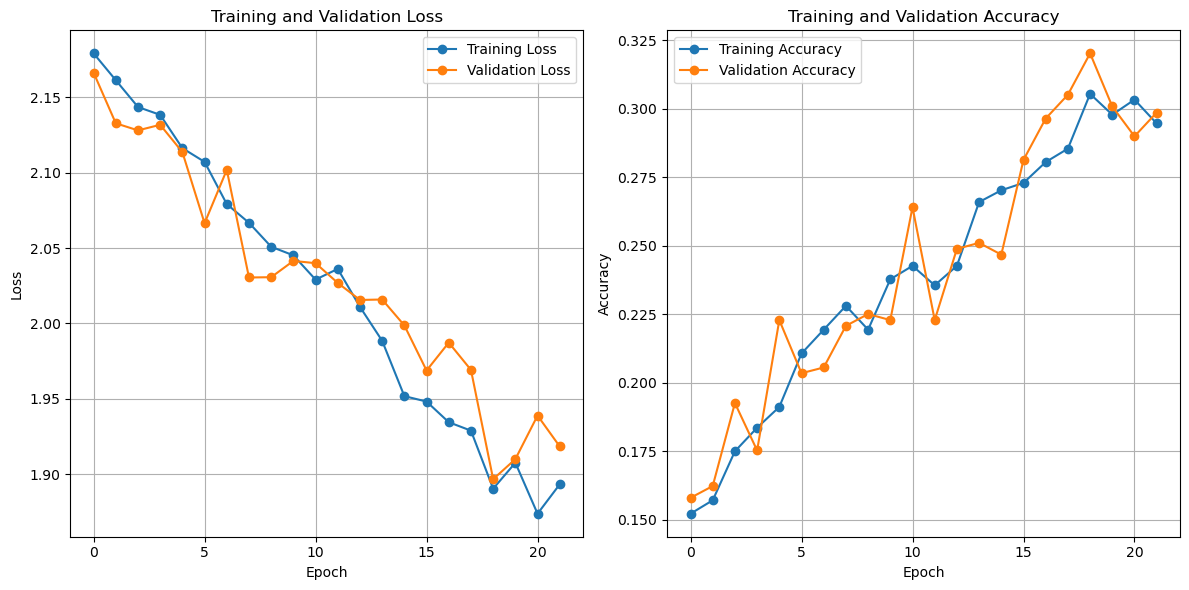

In [53]:
training_report('LOGGING_FOLDER+"train_results_artcoppo64.txt"')

## Testing

Model evaluation

Top-1 Accuracy: 0.3068
Top-3 Accuracy: 0.6157
Macro F1 Score: 0.2796
Weighted F1 Score: 0.2880


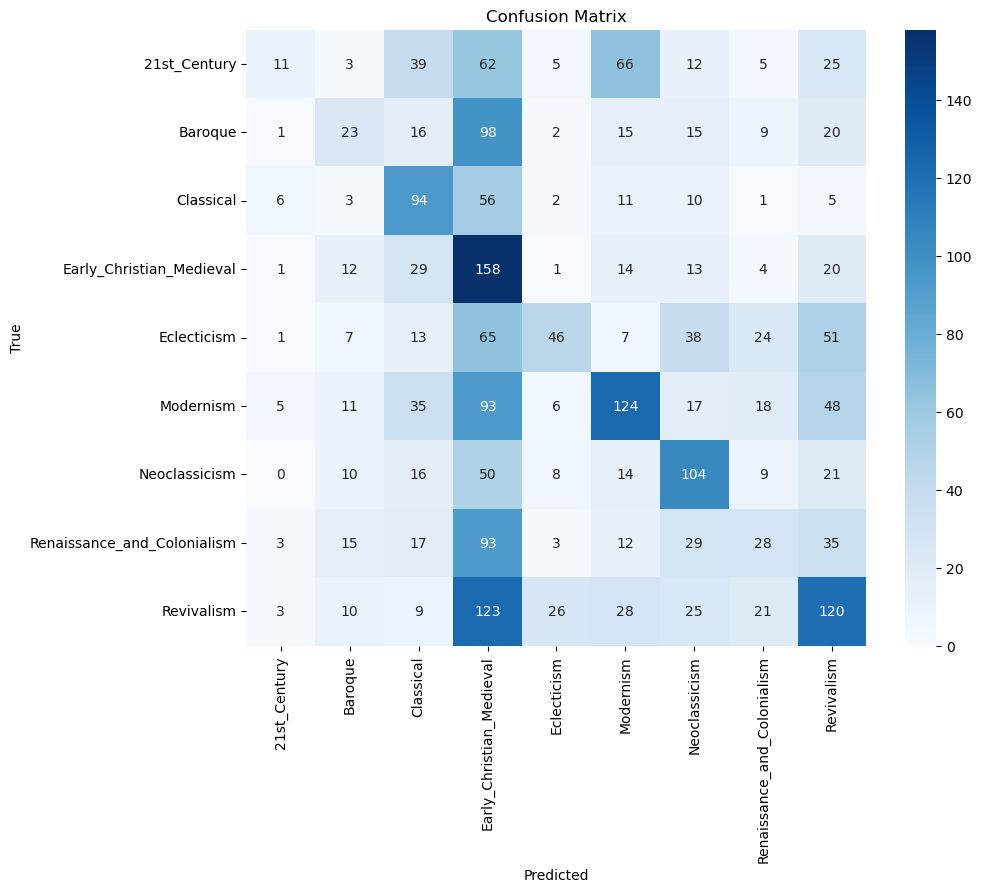

                             precision    recall  f1-score   support

               21st_Century       0.35      0.05      0.08       228
                    Baroque       0.24      0.12      0.16       199
                  Classical       0.35      0.50      0.41       188
   Early_Christian_Medieval       0.20      0.63      0.30       252
                Eclecticism       0.46      0.18      0.26       252
                  Modernism       0.43      0.35      0.38       357
              Neoclassicism       0.40      0.45      0.42       232
Renaissance_and_Colonialism       0.24      0.12      0.16       235
                 Revivalism       0.35      0.33      0.34       365

                   accuracy                           0.31      2308
                  macro avg       0.34      0.30      0.28      2308
               weighted avg       0.34      0.31      0.29      2308



In [64]:
TestReport(artcoppo64, torch.device("cuda" if torch.cuda.is_available() else "cpu"), test_dataset)